# Панкратов Виктор, задание 6
## Визуализировать Lottery Ticket : построить график наилучшего качество от количества сэмплов подсети на выборке MNIST
### Lottery Ticket -- алгоритм, в общем виде состоящий из следующих шагов
1)Инициализация параметров и маски(на начальный момент состоящей из единиц) сети 

2)Оптимизировать парамтеры сети на train-е

3)Использовать критерий, чтобы сопоставить некоторым элементам маски нули

4)Провести некоторые операции с параметрами, соответствующими маске 1

5)Провести некоторые операции с параметрами, соответствующими маске 0

6)Повторить, начиная с шага 1) по необходимости 

В статье, привязанной к заданию (https://arxiv.org/pdf/1905.01067.pdf) этот алгоритм рассматривался как оптимизация маски. Задача - путём такого алгоритма добиться высокого качества(буду оценивать его в виде accuracy на test) в сети без какой-либо тренировки, но с изначально установленной маской. Утверждается(в статье), что можно получить accuracy примерно 80%. 

In [1]:
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm 
import torch.utils.data


In [2]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,transform=torchvision.transforms.ToTensor()),batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,transform=torchvision.transforms.ToTensor()),batch_size=batch_size, shuffle=True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [3]:
class MaskedLinear(nn.Linear):#Обычный линейный слой с маской. Скопирован из дз с другого курса с некоторыми небольшими изменениями.
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [4]:
#Архитектура выбрана случайно и не подбиралась. Как мы увидим позже, не было необходимости. 
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.fc0 = MaskedLinear(28*28,320)
        self.t1 = nn.Tanh() 
        self.fc1 = MaskedLinear(320,80) 
        self.t2 = nn.Tanh()  
        self.fc2 = MaskedLinear(80,40)
        self.t3 = nn.Tanh() 
        self.fc3 = MaskedLinear(40,10)
    def setmasks(self,*masks):
    #Устанавливает маски для линейных слоев сети
        i= 0
        for layer in self.modules():
            if(isinstance(layer, MaskedLinear)):
                layer.set_mask(masks[i])
                i+=1
    def getmasks(self):
    #Возвращает маски для линейных слоев сети
        masks = []
        for layer in self.modules():
            if(isinstance(layer, MaskedLinear)):
                  masks.append(layer.mask.numpy())
        return masks

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.t1(x)
        x = self.fc1(x)
        x = self.t2(x)
        x = self.fc2(x)
        x = self.t3(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim = 0)

In [19]:
def train(net,optimiser,n_epochs):
  net.eval() #Так как в этом и состоит суть задания, в начале оценивается качество без тренировки
  correct = 0
  test_loss = 0
  with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
        output = net(data)
        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
      print('Test Accuracy: {}/{} : {:.0f}%'.format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
  initial_acc = 100. * correct / len(test_loader.dataset)
  for epoch in range(n_epochs):#Для выбранной архитектуры хватило 1 эпохи и дальше этот параметр не подбирается
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      optimiser.zero_grad()
      output = net(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimiser.step()
    net.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():#На всякий случай выводим и результаты после тренировки. Для задания в этом нет смысла
      for batch_idx, (data, target) in enumerate(test_loader):
        output = net(data)
        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
      print('Test Accuracy: {}/{} : {:.0f}%'.format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return(initial_acc)
def find_nonzero_weight(num_iter,p,weights): #находим границу для весов, которые надо обнулить...
  percent = p**(num_iter)
  q = np.quantile(weights,1 - percent) 
  return q

def changemask(net,num_iter,p,oldmasks):#..и обнуляем соответствующие веса
  masks = []
  i = 0
  for layer in net.modules():
    if isinstance(layer, MaskedLinear):
      weight = layer.weight.detach().numpy() * oldmasks[i]
      i += 1
      masks.append(weight**2 > find_nonzero_weight(num_iter,p,weight**2))
  return(masks)
def get_ans_accuracies(p=0.9):
  max_iter = 10 #Зафиксировано для демонстрации ниже 
  net = MnistNet()
  torch.save(net.state_dict(), '/state.st') #Сеть генерируется один раз и дальше тренируется с начального состояния. 
  #Можно было каждый раз случайно инициализировать, если так требуется, можно удалить это и load ниже. Не пробовал
  masks = net.getmasks()
  ans = []
  for i in range(max_iter):
    print(np.sum(masks[0])) #Выводилось для понимания, что параметры действительно обнуляются и на первом шаге обнулился ровно 1
    #Последнее следует из кода выше и необходимо для проверки корректности -- качество на первых двух итерациях не должно сильно меняться
    net = MnistNet()
    net.load_state_dict(torch.load( '/state.st'))
    net.setmasks(*masks)
    optimiser = torch.optim.Adam(net.parameters())
    ans.append(train(net,optimiser,1))
    masks = changemask(net,i,p,masks)
  return ans

In [20]:
ans09 = get_ans_accuracies()

250880.0
Test Accuracy: 726/10000 : 7%
Test Accuracy: 9477/10000 : 95%
250879
Test Accuracy: 721/10000 : 7%
Test Accuracy: 9527/10000 : 95%
225792
Test Accuracy: 5791/10000 : 58%
Test Accuracy: 9527/10000 : 95%
203212
Test Accuracy: 7255/10000 : 73%
Test Accuracy: 9532/10000 : 95%
182891
Test Accuracy: 7622/10000 : 76%
Test Accuracy: 9528/10000 : 95%
164602
Test Accuracy: 7919/10000 : 79%
Test Accuracy: 9555/10000 : 96%
148142
Test Accuracy: 7876/10000 : 79%
Test Accuracy: 9570/10000 : 96%
133328
Test Accuracy: 7917/10000 : 79%
Test Accuracy: 9595/10000 : 96%
119995
Test Accuracy: 8180/10000 : 82%
Test Accuracy: 9587/10000 : 96%
107996
Test Accuracy: 7980/10000 : 80%
Test Accuracy: 9571/10000 : 96%


In [23]:
ans095 = get_ans_accuracies(0.95)

250880.0
Test Accuracy: 1964/10000 : 20%
Test Accuracy: 9518/10000 : 95%
250879
Test Accuracy: 1914/10000 : 19%
Test Accuracy: 9523/10000 : 95%
238336
Test Accuracy: 4322/10000 : 43%
Test Accuracy: 9514/10000 : 95%
226419
Test Accuracy: 6131/10000 : 61%
Test Accuracy: 9516/10000 : 95%
215098
Test Accuracy: 7227/10000 : 72%
Test Accuracy: 9539/10000 : 95%
204343
Test Accuracy: 7520/10000 : 75%
Test Accuracy: 9551/10000 : 96%
194126
Test Accuracy: 7733/10000 : 77%
Test Accuracy: 9516/10000 : 95%
184420
Test Accuracy: 7898/10000 : 79%
Test Accuracy: 9545/10000 : 95%
175199
Test Accuracy: 7998/10000 : 80%
Test Accuracy: 9575/10000 : 96%
166439
Test Accuracy: 7967/10000 : 80%
Test Accuracy: 9549/10000 : 95%


In [25]:
ans08 = get_ans_accuracies(0.8)

250880.0
Test Accuracy: 999/10000 : 10%
Test Accuracy: 9460/10000 : 95%
250879
Test Accuracy: 1022/10000 : 10%
Test Accuracy: 9524/10000 : 95%
200704
Test Accuracy: 7147/10000 : 71%
Test Accuracy: 9554/10000 : 96%
160563
Test Accuracy: 8018/10000 : 80%
Test Accuracy: 9565/10000 : 96%
128451
Test Accuracy: 8252/10000 : 83%
Test Accuracy: 9571/10000 : 96%
102761
Test Accuracy: 8093/10000 : 81%
Test Accuracy: 9567/10000 : 96%
82209
Test Accuracy: 7613/10000 : 76%
Test Accuracy: 9607/10000 : 96%
65767
Test Accuracy: 7505/10000 : 75%
Test Accuracy: 9608/10000 : 96%
52614
Test Accuracy: 7210/10000 : 72%
Test Accuracy: 9592/10000 : 96%
42091
Test Accuracy: 7574/10000 : 76%
Test Accuracy: 9575/10000 : 96%


In [26]:
ans05 = get_ans_accuracies(0.5)

250880.0
Test Accuracy: 793/10000 : 8%
Test Accuracy: 9495/10000 : 95%
250879
Test Accuracy: 800/10000 : 8%
Test Accuracy: 9457/10000 : 95%
125440
Test Accuracy: 7683/10000 : 77%
Test Accuracy: 9569/10000 : 96%
62720
Test Accuracy: 6999/10000 : 70%
Test Accuracy: 9561/10000 : 96%
31360
Test Accuracy: 5618/10000 : 56%
Test Accuracy: 9472/10000 : 95%
15680
Test Accuracy: 5060/10000 : 51%
Test Accuracy: 9323/10000 : 93%
7840
Test Accuracy: 4932/10000 : 49%
Test Accuracy: 8236/10000 : 82%
3920
Test Accuracy: 4452/10000 : 45%
Test Accuracy: 6511/10000 : 65%
1960
Test Accuracy: 3577/10000 : 36%
Test Accuracy: 4709/10000 : 47%
980
Test Accuracy: 2424/10000 : 24%
Test Accuracy: 2902/10000 : 29%


In [27]:
ans07 = get_ans_accuracies(0.5)

250880.0
Test Accuracy: 783/10000 : 8%
Test Accuracy: 9510/10000 : 95%
250879
Test Accuracy: 766/10000 : 8%
Test Accuracy: 9528/10000 : 95%
125440
Test Accuracy: 7697/10000 : 77%
Test Accuracy: 9537/10000 : 95%
62720
Test Accuracy: 7518/10000 : 75%
Test Accuracy: 9580/10000 : 96%
31360
Test Accuracy: 6374/10000 : 64%
Test Accuracy: 9492/10000 : 95%
15680
Test Accuracy: 5421/10000 : 54%
Test Accuracy: 9306/10000 : 93%
7840
Test Accuracy: 5147/10000 : 51%
Test Accuracy: 7379/10000 : 74%
3920
Test Accuracy: 3954/10000 : 40%
Test Accuracy: 5626/10000 : 56%
1960
Test Accuracy: 3305/10000 : 33%
Test Accuracy: 4698/10000 : 47%
980
Test Accuracy: 1933/10000 : 19%
Test Accuracy: 2712/10000 : 27%


Text(0.5, 1.0, 'Lottery ticket model accuracy,p = 0.95')

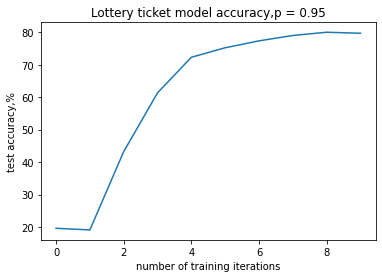

In [24]:
plt.plot(np.arange(0,10,1),ans095)
plt.xlabel("number of training iterations")
plt.ylabel("test accuracy,%")
plt.title("Lottery ticket model accuracy,p = 0.95")

Text(0.5, 1.0, 'Lottery ticket model accuracy,p = 0.9')

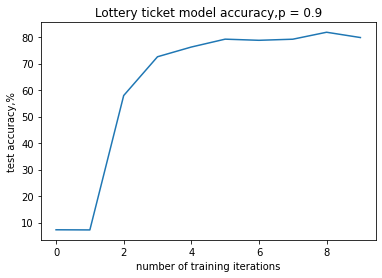

In [22]:
plt.plot(np.arange(0,10,1),ans09)
plt.xlabel("number of training iterations")
plt.ylabel("test accuracy,%")
plt.title("Lottery ticket model accuracy,p = 0.9")

Text(0.5, 1.0, 'Lottery ticket model accuracy,p = 0.8')

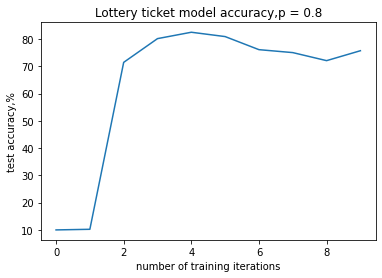

In [28]:
plt.plot(np.arange(0,10,1),ans08)
plt.xlabel("number of training iterations")
plt.ylabel("test accuracy,%")
plt.title("Lottery ticket model accuracy,p = 0.8")

Text(0.5, 1.0, 'Lottery ticket model accuracy,p = 0.7')

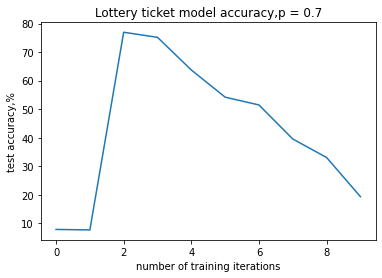

In [29]:
plt.plot(np.arange(0,10,1),ans07)
plt.xlabel("number of training iterations")
plt.ylabel("test accuracy,%")
plt.title("Lottery ticket model accuracy,p = 0.7")

Text(0.5, 1.0, 'Lottery ticket model accuracy,p = 0.5')

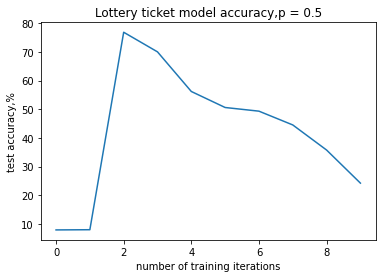

In [30]:
plt.plot(np.arange(0,10,1),ans05)
plt.xlabel("number of training iterations")
plt.ylabel("test accuracy,%")
plt.title("Lottery ticket model accuracy,p = 0.5")

# Пояснение к результатам
Для шагов 0-1 - см комментарии к коду, фактически это один и тот же шаг.После этого мы видим, что почти везде подъем accuracy идет сразу, причем для меньших p за один шаг,для больших необходимо проводить дополнительные итерации. Однако при малых p($\leq 0.7$) обнуляется слишком большое число параметров. В нашей сети было необходимо примерно 50000 суммарно, то есть пятая часть от исходных и когда их становилось меньше, качество начинало резко падать. Зависимость доли от архитектуры не проверялась, но accuracy 75% была достигнута на некоторых графиках при именно такой доле параметров, что согласуется с результатами статьи(~80, 80 было при меньшем числе удаленных парметров на других p)